## Name: Luke Pratley
## Date Week 6

## EDA and Mask generation for Las Vegas Building Footprint detection

In [1]:
%matplotlib inline
import sys, os
sys.path.insert(0,os.path.abspath('../../building_road_segmentation'))

import building_road_segmentation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

import geopandas as gpd
import rasterio
import rasterio.features
from rasterio.merge import merge
from rasterio.plot import show


In [2]:
data_directory = 'D:\Capstone Project\data\\'
datasets = glob.glob(data_directory + '*_Train')
datasets = [d.split('\\')[-1] for d in datasets]
dataset_index = 0
datasets

['AOI_2_Vegas_Train',
 'AOI_3_Paris_Train',
 'AOI_4_Shanghai_Train',
 'AOI_5_Khartoum_Train']

Below we are creating a dictionary that makes it easier to keep track of the image directories.

In [3]:
directories_dict = building_road_segmentation.get_directories_dictionary(data_directory, dataset_index)
directories_dict

{'MUL': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL',
 'MUL-PanSharpen': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL-PanSharpen',
 'PAN': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\PAN',
 'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\RGB-PanSharpen',
 'building_mask': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\building_mask',
 'geojson': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\geojson',
 'road_mask': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\road_mask'}

Below I am listing the directories in the dataset. 

In [4]:
directories = glob.glob(data_directory + f'{datasets[dataset_index]}\*')
directories.sort()

directories

['D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL-PanSharpen',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\PAN',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\RGB-PanSharpen',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\building_mask',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\geojson',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\road_mask',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\summaryData']

## Data Cleaning

Here we are reading in information about the labels; the table containing the building locations:

In [5]:
building_info_df = gpd.read_file(glob.glob(directories[-1]+'\*')[0])

In [6]:
building_info_df.head(10)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((68.71 623.1 0,35.71 618.15 0,33.59 6...","POLYGON ((-115.27398708 36.20208033800003 0,-1...",None
1,AOI_2_Vegas_img1209,2,"POLYGON ((221.33 645.02 0,185.7 640.33 0,184.4...",POLYGON ((-115.273575016999985 36.202021143000...,None
2,AOI_2_Vegas_img1209,3,"POLYGON ((150.3 650.0 0,160.9 650.0 0,150.58 6...",POLYGON ((-115.273766779991007 36.202007699876...,None
3,AOI_2_Vegas_img1209,4,"POLYGON ((141.86 636.02 0,98.99 630.03 0,99.57...",POLYGON ((-115.273789578999981 36.202045452000...,None
4,AOI_2_Vegas_img1209,5,"POLYGON ((227.4 650.0 0,240.73 650.0 0,227.69 ...",POLYGON ((-115.273558615661273 36.202007699876...,None
5,AOI_2_Vegas_img1209,6,"POLYGON ((0.0 462.3 0,0.0 514.64 0,14.34 516.6...",POLYGON ((-115.27417259993355 36.2025144913411...,None
6,AOI_2_Vegas_img1209,7,"POLYGON ((75.45 470.47 0,64.63 522.25 0,68.61 ...",POLYGON ((-115.273968876999959 36.202492435000...,None
7,AOI_2_Vegas_img1209,8,"POLYGON ((525.36 590.77 0,535.43 539.72 0,468....",POLYGON ((-115.272754125999938 36.202167611000...,None
8,AOI_2_Vegas_img1209,9,"POLYGON ((298.69 504.61 0,232.44 495.23 0,225....",POLYGON ((-115.273366127999964 36.202400240000...,None
9,AOI_2_Vegas_img1209,10,"POLYGON ((376.15 520.27 0,310.24 511.95 0,300....",POLYGON ((-115.273156992999986 36.202357965000...,None


In [7]:
building_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 110042 entries, 0 to 110041
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ImageId         110042 non-null  object  
 1   BuildingId      110042 non-null  object  
 2   PolygonWKT_Pix  110042 non-null  object  
 3   PolygonWKT_Geo  110042 non-null  object  
 4   geometry        0 non-null       geometry
dtypes: geometry(1), object(4)
memory usage: 4.2+ MB


We are changing the building ID to an integer then check if there are any negative values:

In [8]:
building_info_df['BuildingId'] = building_info_df['BuildingId'].astype(int)

In [9]:
building_info_df[building_info_df['BuildingId'] < 1]

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
512,AOI_2_Vegas_img2245,-1,POLYGON EMPTY,POLYGON EMPTY,None
1247,AOI_2_Vegas_img482,-1,POLYGON EMPTY,POLYGON EMPTY,None
2111,AOI_2_Vegas_img35,-1,POLYGON EMPTY,POLYGON EMPTY,None
3449,AOI_2_Vegas_img671,-1,POLYGON EMPTY,POLYGON EMPTY,None
4167,AOI_2_Vegas_img4819,-1,POLYGON EMPTY,POLYGON EMPTY,None
...,...,...,...,...,...
107093,AOI_2_Vegas_img4876,-1,POLYGON EMPTY,POLYGON EMPTY,None
107797,AOI_2_Vegas_img5047,-1,POLYGON EMPTY,POLYGON EMPTY,None
107829,AOI_2_Vegas_img1910,-1,POLYGON EMPTY,POLYGON EMPTY,None
108735,AOI_2_Vegas_img1164,-1,POLYGON EMPTY,POLYGON EMPTY,None


We will now see if we should remove all of these rows by checking if they are all empty polygons.

In [10]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Pix'].value_counts()

POLYGON EMPTY    235
Name: PolygonWKT_Pix, dtype: int64

In [11]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Geo'].value_counts()

POLYGON EMPTY    235
Name: PolygonWKT_Geo, dtype: int64

They are all empty and we will drop these rows

In [12]:
building_info_df = building_info_df[building_info_df['BuildingId'] > 0]

We will now check if there are any other empty polygons.

In [13]:
building_info_df[building_info_df['PolygonWKT_Pix'] == 'POLYGON EMPTY']

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
9322,AOI_2_Vegas_img1198,49,POLYGON EMPTY,POLYGON ((-115.272417599930051 36.184352627988...,None
17855,AOI_2_Vegas_img2672,2,POLYGON EMPTY,POLYGON ((-115.234576596138936 36.189722699852...,None
32907,AOI_2_Vegas_img156,12,POLYGON EMPTY,POLYGON ((-115.303509211572162 36.205517699883...,None
53586,AOI_2_Vegas_img3941,12,POLYGON EMPTY,POLYGON ((-115.2057275997971 36.19824056360369...,None
56860,AOI_2_Vegas_img4967,18,POLYGON EMPTY,POLYGON ((-115.184522266983819 36.196742699866...,None
102773,AOI_2_Vegas_img966,1,POLYGON EMPTY,"POLYGON ((-115.2798818 36.23184270400003 0,-11...",None
105069,AOI_2_Vegas_img889,36,POLYGON EMPTY,POLYGON ((-115.281496853999954 36.213140674000...,None


In [14]:
building_info_df[building_info_df['PolygonWKT_Geo'] == 'POLYGON EMPTY']

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry


We drop the rows with empty polygons because it is likely they are not actually in the image. Also it is just more than a handful of rows... It is not a big loss! Maybe we can consider using the geospatial coordinates to repear these values.

In [15]:
building_info_df = building_info_df[building_info_df['PolygonWKT_Pix'] != 'POLYGON EMPTY']

Now we are going to check for null values:

In [16]:
building_info_df.isna().sum()

ImageId                0
BuildingId             0
PolygonWKT_Pix         0
PolygonWKT_Geo         0
geometry          109800
dtype: int64

There are no null values except for geometry.

In [17]:
pd.DataFrame(building_info_df['geometry']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109800 entries, 0 to 110041
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  0 non-null      geometry
dtypes: geometry(1)
memory usage: 1.7 MB


All of the values are null. I am not sure what the column is for, but I am thinking I will drop it for now since I am not sure why it is useful as it is.

In [18]:
building_info_df.drop(columns=['geometry'], axis=1, inplace=True)

In [19]:
building_info_df.head(10)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_2_Vegas_img1209,1,"POLYGON ((68.71 623.1 0,35.71 618.15 0,33.59 6...","POLYGON ((-115.27398708 36.20208033800003 0,-1..."
1,AOI_2_Vegas_img1209,2,"POLYGON ((221.33 645.02 0,185.7 640.33 0,184.4...",POLYGON ((-115.273575016999985 36.202021143000...
2,AOI_2_Vegas_img1209,3,"POLYGON ((150.3 650.0 0,160.9 650.0 0,150.58 6...",POLYGON ((-115.273766779991007 36.202007699876...
3,AOI_2_Vegas_img1209,4,"POLYGON ((141.86 636.02 0,98.99 630.03 0,99.57...",POLYGON ((-115.273789578999981 36.202045452000...
4,AOI_2_Vegas_img1209,5,"POLYGON ((227.4 650.0 0,240.73 650.0 0,227.69 ...",POLYGON ((-115.273558615661273 36.202007699876...
5,AOI_2_Vegas_img1209,6,"POLYGON ((0.0 462.3 0,0.0 514.64 0,14.34 516.6...",POLYGON ((-115.27417259993355 36.2025144913411...
6,AOI_2_Vegas_img1209,7,"POLYGON ((75.45 470.47 0,64.63 522.25 0,68.61 ...",POLYGON ((-115.273968876999959 36.202492435000...
7,AOI_2_Vegas_img1209,8,"POLYGON ((525.36 590.77 0,535.43 539.72 0,468....",POLYGON ((-115.272754125999938 36.202167611000...
8,AOI_2_Vegas_img1209,9,"POLYGON ((298.69 504.61 0,232.44 495.23 0,225....",POLYGON ((-115.273366127999964 36.202400240000...
9,AOI_2_Vegas_img1209,10,"POLYGON ((376.15 520.27 0,310.24 511.95 0,300....",POLYGON ((-115.273156992999986 36.202357965000...


We check for duplicates. It is clear that the columns PolygonWKT_Pix and PolygonWKT_Geo hold the same information, but one is in pixel coordinates and the other is in geospatial coordinates. Both of these are useful depending on how the coordinate system, it is much easier to keep both than convert between coordinates manually for now.

In [20]:
building_info_df[building_info_df.duplicated()]

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo


We can see that there are no duplicate rows from the above cell.

We are now going to check for duplicate building Ids:

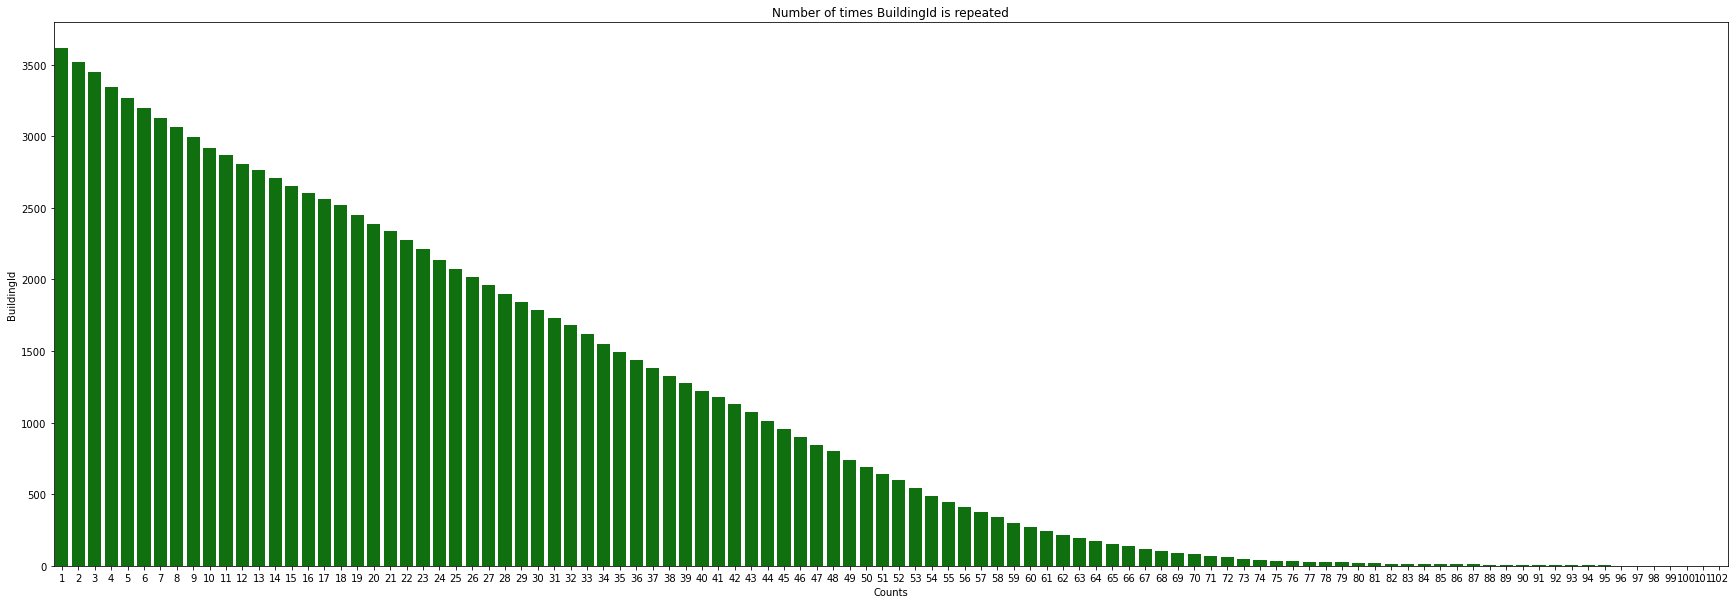

In [21]:
plt.figure(figsize=(30, 10))
plt.title('Number of times BuildingId is repeated')
sns.barplot(data=pd.DataFrame(building_info_df['BuildingId']).value_counts().reset_index(), x='BuildingId', y=0, color = 'green')
plt.ylabel('BuildingId')
plt.xlabel('Counts')
plt.show()

In [22]:
building_info_df['BuildingId'].unique().shape[0]

102

There are only 102 buildings in this area.

In [23]:
image_names = np.array(building_info_df['ImageId'].unique().astype(str))
image_names.sort()
print(f'We expect to have this many images (of a given type): {image_names.shape[0]}')

We expect to have this many images (of a given type): 3616


Lastly, we are going to check that a BuildingId does not appear twice within the same image.

In [24]:
for im in image_names:
    if building_info_df[building_info_df['ImageId'] == im]['BuildingId'].duplicated().sum() > 0:
        print(f'{im} has at least one duplicate BuildingId. You need to investigate!')

Now we are going to investigate the image directories. We can check that all of the files we expect exist from the `image_names` list that we created.

In [25]:
directories_dict

{'MUL': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL',
 'MUL-PanSharpen': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\MUL-PanSharpen',
 'PAN': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\PAN',
 'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\RGB-PanSharpen',
 'building_mask': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\building_mask',
 'geojson': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\geojson',
 'road_mask': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\road_mask'}

We are using a custom function that takes this dictionary and creates a path from a given folder name and image name.

It turns out that to plot the building locations using geopandas we need to read the geojson file for each image into the geopandas dataframe. This means that the dataframe from summaryData is not the correct one for plotting information.

Below we are checking that none of the image files are missing given that we know the image for each of the buildings that we have:

In [26]:
for im in image_names:
    for key, item in directories_dict.items():
        if key != 'geojson' and key !='building_mask' and key !='road_mask':
            file_path = building_road_segmentation.get_image_path(directories_dict, key, im)
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')
        elif key == 'geojson':
            file_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')

We can check what the type and shape is for each image:

In [27]:
shape_dictionary = dict()
for key, item in directories_dict.items():
    if key != 'geojson' and key !='building_mask' and key !='road_mask':
        with rasterio.open(building_road_segmentation.get_image_path(directories_dict, key, image_names[0])) as image:
            shape_dictionary[key] = image.read().shape
            print(type(image))
            print(type(image.read()))
shape_dictionary

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>


{'MUL': (8, 163, 163),
 'MUL-PanSharpen': (8, 650, 650),
 'PAN': (1, 650, 650),
 'RGB-PanSharpen': (3, 650, 650)}

From the website, we expect our observations to be of the form:

MS             > Raw source geotiffs of 8-Band Multi-Spectral raster data from WorldView-3

PS-MS          > Raw source geotiffs and COGs of 8-Band Multi-Spectral raster data pansharpened to 0.3m

PAN            > Raw source geotiffs of Panchromatic raster data from Worldview-3

PS-RGB         > Raw source geotiffs of RGB raster data from Worldview-3 pansharpened to 0.3m



In [28]:
print(len(image_names))

3616


In [29]:
#for im in image_names:
#    for key, item in directories_dict.items():
        #with rasterio.open(get_image_path(key, im)) as image:
        #    if shape_dictionary[key] != image.shape:
        #        print(f'{item} has a different image size from what was expected.')

Now we take a look at what an image looks like for each folder:

AOI_2_Vegas_img1004


C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  verti

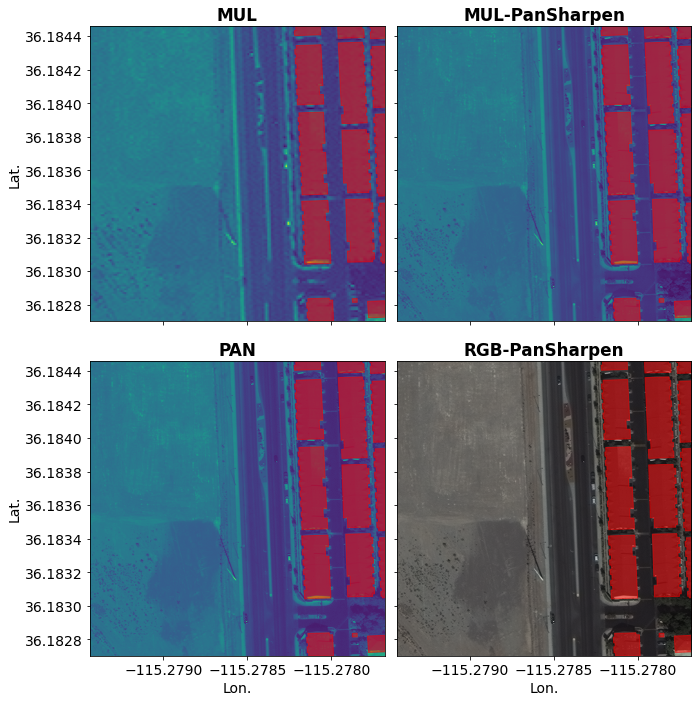

In [30]:
print(image_names[4])
building_road_segmentation.plot_images(directories_dict, image_names[4])

C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


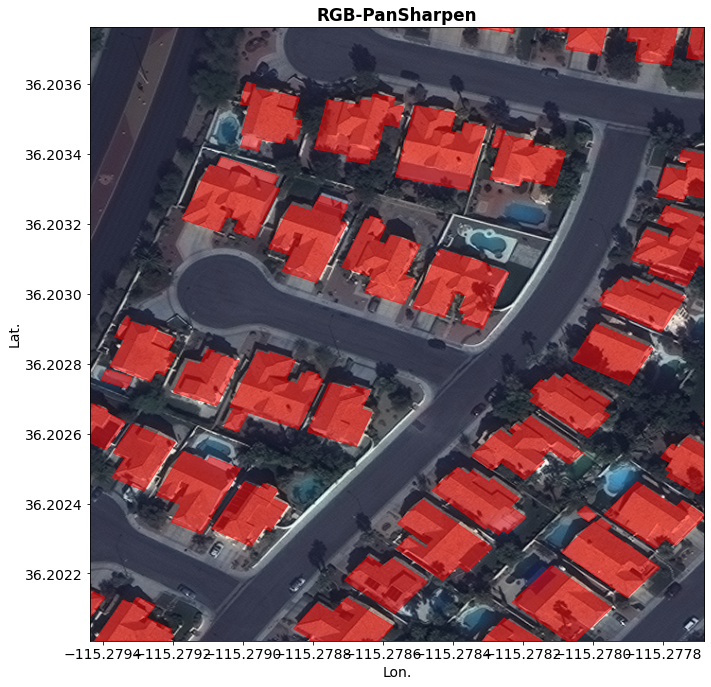

In [152]:
building_road_segmentation.plot_image(directories_dict, image_names[10])

The above plot was mading using the geopandas dictionary:

In [153]:
building_road_segmentation.get_geopandas_for_image(directories_dict, image_names[5])

,OBJECTID,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec,geometry
0,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000182,0.0,0.0,1.000000,"POLYGON Z ((-115.27899 36.18623 0.00000, -115...."
1,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000780,0.0,1.0,0.184249,"POLYGON Z ((-115.27768 36.18683 0.00000, -115...."
2,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000910,0.0,0.0,1.000000,"POLYGON Z ((-115.27803 36.18693 0.00000, -115...."
3,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000795,0.0,1.0,0.206081,"POLYGON Z ((-115.27768 36.18701 0.00000, -115...."
4,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000776,0.0,1.0,0.217228,"POLYGON Z ((-115.27768 36.18716 0.00000, -115...."
5,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000713,0.0,0.0,1.000000,"POLYGON Z ((-115.27797 36.18724 0.00000, -115...."
6,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000718,0.0,0.0,1.000000,"POLYGON Z ((-115.27821 36.18724 0.00000, -115...."
7,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000926,0.0,0.0,1.000000,"POLYGON Z ((-115.27771 36.18746 0.00000, -115...."
8,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000810,0.0,0.0,1.000000,"POLYGON Z ((-115.27801 36.18764 0.00000, -115...."
9,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000848,0.0,0.0,1.000000,"POLYGON Z ((-115.27821 36.18765 0.00000, -115...."


We need a function to create images for the masks that the ML method will predict. We need to create our polygon objects and check what pixels lie within them. Below we use functionality from rasterio to do this with the geometry object from geopandas:

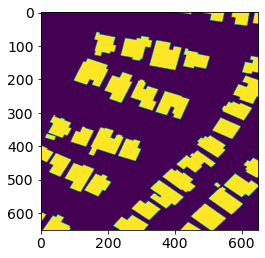

In [154]:
plt.imshow(building_road_segmentation.create_mask(directories_dict, image_names[10]))

In [155]:
np.save(datasets[dataset_index] + '_image_names', image_names)

In [156]:
import time


count  = 0
for k, im in enumerate(image_names):
    assert not os.path.exists(building_road_segmentation.get_building_mask_path(directories_dict, im)), "Mask already exists!"
    with open(building_road_segmentation.get_building_mask_path(directories_dict, im), 'wb') as f:

        count += 1
        np.save(f, building_road_segmentation.create_mask(directories_dict, im))
        if k % 500 == 0:
            print(k, im)

AssertionError: Mask already exists!

C:\Users\lukep\miniconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


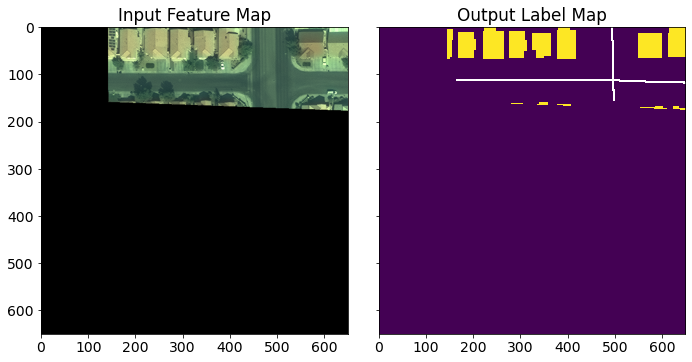

In [157]:
building_road_segmentation.plot_features_labels(directories_dict,image_names[0])

In [158]:
with rasterio.open(building_road_segmentation.get_image_path(directories_dict, 'RGB-PanSharpen', image_names[0])) as image:
    print(image.read().astype(np.uint8).nbytes /1024 /1024)
    print(image.read().dtype)

1.2087821960449219
uint16


In [159]:
len(image_names) 

3616

# Further cleaning can be done by dropping images that have no roads labeled

In [160]:
count_no_roads = 0
count_nan_image = 0
key = 'RGB-PanSharpen'
images_to_keep = np.ones_like(image_names, dtype=bool)

for k, image_name in enumerate(image_names):
    road_mask = building_road_segmentation.load_road_mask(directories_dict, image_name)
    with rasterio.open(building_road_segmentation.get_image_path(directories_dict, key, image_name)) as image:
        img = image.read()
        fraction_nans = (img.size - np.count_nonzero(img))/img.size
    if road_mask.sum() < 50:
        print(image_name)
        count_no_roads += 1
        images_to_keep[k] = False
        #building_road_segmentation.plot_features_labels(directories_dict, image_name)
    if fraction_nans > 0.5:
        print(image_name)
        count_nan_image += 1
        images_to_keep[k] = False
        #building_road_segmentation.plot_features_labels(directories_dict, image_name)
print(count_no_roads)
print(count_nan_image)

AOI_2_Vegas_img1
AOI_2_Vegas_img10
AOI_2_Vegas_img101
AOI_2_Vegas_img1017
AOI_2_Vegas_img1018
AOI_2_Vegas_img1023
AOI_2_Vegas_img1029
AOI_2_Vegas_img1030
AOI_2_Vegas_img1034
AOI_2_Vegas_img1038
AOI_2_Vegas_img1039
AOI_2_Vegas_img1041
AOI_2_Vegas_img1042
AOI_2_Vegas_img1047
AOI_2_Vegas_img1048
AOI_2_Vegas_img1053
AOI_2_Vegas_img1063
AOI_2_Vegas_img1080
AOI_2_Vegas_img1089
AOI_2_Vegas_img1090
AOI_2_Vegas_img1100
AOI_2_Vegas_img1102
AOI_2_Vegas_img1103
AOI_2_Vegas_img1104
AOI_2_Vegas_img1111
AOI_2_Vegas_img1112
AOI_2_Vegas_img1126
AOI_2_Vegas_img1127
AOI_2_Vegas_img1129
AOI_2_Vegas_img1130
AOI_2_Vegas_img1136
AOI_2_Vegas_img1138
AOI_2_Vegas_img1141
AOI_2_Vegas_img1142
AOI_2_Vegas_img1149
AOI_2_Vegas_img116
AOI_2_Vegas_img1167
AOI_2_Vegas_img117
AOI_2_Vegas_img1176
AOI_2_Vegas_img1190
AOI_2_Vegas_img1193
AOI_2_Vegas_img1194
AOI_2_Vegas_img1200
AOI_2_Vegas_img1201
AOI_2_Vegas_img1202
AOI_2_Vegas_img1205
AOI_2_Vegas_img1213
AOI_2_Vegas_img1214
AOI_2_Vegas_img1233
AOI_2_Vegas_img1234
AOI_2_Ve

# Create Final list of good names

In [161]:
len(image_names[images_to_keep])

2099

In [162]:
np.save(datasets[dataset_index] + '_image_names_to_keep', image_names[images_to_keep])